## Imports

In [1]:
!pip install transformers torch torchvision Pillow
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
from PIL import Image

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BertTokenizer
from torchvision import transforms
from transformers import BertModel
from torchvision import models
import torch.nn as nn

In [6]:
# à modifier selon votre chemin

base_path = "/content/drive/MyDrive/FIE5/Ptut/"

csv_physique = base_path + "inventaire_physique.csv"
csv_comptable = base_path + "inventaire_comptable.csv"
img_folder = base_path + "Images/"

## Préparation des données

1/ Inventaire physique réduit => columns : Img/Titre/codeEtiquette/NumInventaire

2/ Inventaire comptable => NumInventaire/des1/fournisseur

3/ lien entre les 2 (numInventaire) => correspondances réelles

In [17]:
df_physique = pd.read_csv(csv_physique)
df_comptable = pd.read_csv(csv_comptable,sep=";",encoding="latin-1")

/tmp/ipython-input-3699852166.py:1: DtypeWarning: Columns (1,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_physique = pd.read_csv(csv_physique)


In [18]:
print(df_physique.columns.tolist())
print(df_comptable.columns.tolist())


['Titre', 'Code Étiquette', 'Date Création', 'Catégorie Parent', 'Sous Catégorie', 'Localisation', 'UF', 'Statut', 'Num Produit', 'Description', 'Img', 'Etat', 'Date modif statut', 'Num Fiche Amortissement', 'Num Commande', 'Num Inventaire', 'Fournisseur']
['numFicheAmortissement', 'des1', 'des2', 'quantite', 'mtOrigine', 'numInventaire', 'dateReception', 'dureeFiche', 'dateFin', 'uf', 'libelleUf', 'numCommande', 'fournisseur']


In [23]:
# Harmonisation du NumInventaire
df_physique = df_physique.rename(columns={"Num Inventaire": "NumInventaire"})
df_comptable = df_comptable.rename(columns={"numInventaire": "NumInventaire"})

# Supprime les lignes sans identifiant
df_physique = df_physique.dropna(subset=["NumInventaire"])
df_comptable = df_comptable.dropna(subset=["NumInventaire"])

In [27]:
# Création df commun
df_merged = pd.merge(
    df_physique,
    df_comptable,
    on="NumInventaire",
    how="inner"
)

print(len(df_merged), "correspondances trouvées dans le dataset")

6894 correspondances trouvées dans le dataset


In [28]:
# Création d’un texte descriptif pour chaque fiche comptable
df_merged["fiche_textuelle"] = (
    df_merged["des1"].fillna('') + " " +
    df_merged["des2"].fillna('') + " " +
    df_merged["fournisseur"].fillna('')
).str.strip()

# Sélection des colonnes importantes
df_final = df_merged[[
    "Titre",
    "Img",
    "NumInventaire",
    "fiche_textuelle"
]]

print(df_final.head(3))

    Titre                                       Img NumInventaire  \
0  Chaise  b7c180e6-13d0-4365-afe7-c83a25746d8d.jpg     202000166   
1  Chaise  c88762c5-3c03-4ad2-8a8a-b02add20dc4d.jpg     202000166   
2  Chaise  63474d32-c1a6-44c1-b3f5-62bdcc2f8d24.jpg       9616256   

                                     fiche_textuelle  
0      CHAISE APPUI SUR TABLE LOLA REF. 2748678 UGAP  
1      CHAISE APPUI SUR TABLE LOLA REF. 2748678 UGAP  
2  CHAISE EMPILABLE 250 ASSISE ET DOSSIER BOIS CO...  


In [30]:
# réduction à 100 lignes aléatoires
df_test_sample = df_final.sample(n=100, random_state=42).reset_index(drop=True)

## Préparation (à adapter selon le modèle)

### Préparation du dataset

In [43]:
class ImageTextDataset(Dataset):
    def __init__(self, df, img_folder, tokenizer, max_length=128, transform=None):
        self.df = df
        self.img_folder = img_folder
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # --- Image ---
        img_path = f"{self.img_folder}{row['Img']}"
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # --- Texte ---
        text = str(row['fiche_textuelle'])
        encoded = self.tokenizer(text,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=self.max_length,
                                 return_tensors='pt')

        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        return image, input_ids, attention_mask


### Transformation des images

In [33]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


### Initialisation des encoders

In [35]:
# Vision encoder
vision_encoder = models.resnet50(pretrained=True)
vision_encoder.fc = nn.Identity()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 52.3MB/s]


In [36]:
# text encoder
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_encoder = BertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Création du dataloader

In [44]:
dataset = ImageTextDataset(df_test_sample, img_folder=img_folder, tokenizer=tokenizer, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


## Définition du modèle

In [48]:
class ImageTextModel(nn.Module):
    def __init__(self, vision_encoder, text_encoder, embed_dim=512):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.text_encoder = text_encoder
        self.img_proj = nn.Linear(2048, embed_dim)   # ResNet50 output dim = 2048
        self.txt_proj = nn.Linear(768, embed_dim)    # BERT output dim = 768

    def forward(self, images, input_ids, attention_mask):
        # Image embeddings
        img_feats = self.vision_encoder(images)
        img_embeds = self.img_proj(img_feats)

        # Texte embeddings
        txt_feats = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        txt_embeds = self.txt_proj(txt_feats)

        # Normalisation
        img_embeds = nn.functional.normalize(img_embeds, p=2, dim=1)
        txt_embeds = nn.functional.normalize(txt_embeds, p=2, dim=1)

        return img_embeds, txt_embeds


Définition du Loss constrative

In [49]:
def clip_loss(image_embeds, text_embeds, temperature=0.07):
    logits = image_embeds @ text_embeds.t() / temperature
    labels = torch.arange(len(logits), device=logits.device)
    loss_i2t = nn.CrossEntropyLoss()(logits, labels)
    loss_t2i = nn.CrossEntropyLoss()(logits.t(), labels)
    return (loss_i2t + loss_t2i) / 2


## Vérification

In [50]:
sample_image, sample_input_ids, sample_attention_mask = dataset[0]

print(sample_image.shape)
print(sample_input_ids.shape)
print(sample_attention_mask.shape)


torch.Size([3, 224, 224])
torch.Size([128])
torch.Size([128])


In [ ]:
vision_encoder.eval()
with torch.no_grad():
    img_feat = vision_encoder(sample_image.unsqueeze(0))  # ajouter batch dimension
print(img_feat.shape)  # devrait être [1, 2048] pour ResNet50


torch.Size([1, 2048])


In [ ]:
text_encoder.eval()
with torch.no_grad():
    encoded = text_encoder(input_ids=sample_input_ids.unsqueeze(0),
                           attention_mask=sample_attention_mask.unsqueeze(0))
    txt_feat = encoded.pooler_output
print(txt_feat.shape)  # devrait être [1, 768] pour BERT


torch.Size([1, 768])


## Initialisation du modèle

In [55]:
model = ImageTextModel(vision_encoder, text_encoder).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

### Entrainement du modèle

In [56]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (images, input_ids, attention_mask) in enumerate(dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        optimizer.zero_grad()

        img_embeds, txt_embeds = model(images, input_ids, attention_mask)

        loss = clip_loss(img_embeds, txt_embeds)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss moyenne: {avg_loss:.4f}")

Epoch 1/5 - Loss moyenne: 1.9726
Epoch 2/5 - Loss moyenne: 1.7737
Epoch 3/5 - Loss moyenne: 1.6334
Epoch 4/5 - Loss moyenne: 1.5702
Epoch 5/5 - Loss moyenne: 1.3209


### Embeddings du dataset

In [65]:
all_images = []
for img_name in df_test_sample["Img"]:
    img_path = f"{img_folder}{img_name}"
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    all_images.append(img_tensor)

all_images = torch.stack(all_images).to(device)

In [69]:
# Assure-toi d'avoir ton tokenizer BERT
# Exemple : tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Transformer toutes les fiches textuelles en input_ids et attention_mask
text_inputs = tokenizer(
    list(df_test_sample["fiche_textuelle"]),
    padding=True,            # remplit pour que tous les textes aient la même longueur
    truncation=True,         # coupe les textes trop longs
    max_length=128,          # longueur max (tu peux ajuster)
    return_tensors='pt'      # renvoie des tenseurs PyTorch
)

all_input_ids = text_inputs['input_ids'].to(device)
all_attention_mask = text_inputs['attention_mask'].to(device)

print("Shape all_input_ids:", all_input_ids.shape)
print("Shape all_attention_mask:", all_attention_mask.shape)


Shape all_input_ids: torch.Size([100, 40])
Shape all_attention_mask: torch.Size([100, 40])


In [70]:
model.eval()
with torch.no_grad():
    img_embeds = model.vision_encoder(all_images)
    img_embeds = nn.functional.normalize(model.img_proj(img_embeds), p=2, dim=1)

    txt_embeds = model.text_encoder(input_ids=all_input_ids, attention_mask=all_attention_mask).pooler_output
    txt_embeds = nn.functional.normalize(model.txt_proj(txt_embeds), p=2, dim=1)


## Evaluation du modèle

Temps total pour calculer les similarités : 0.00 sec
Temps moyen par image : 0.0000 sec
Utilisation mémoire : 7680.98 MB
{'Top-1 Accuracy': 0.2, 'Top-5 Accuracy': 0.6, 'MRR': np.float64(0.3774412373172544), 'Precision@5': 0.1199999999999999, 'Recall@5': 0.6}
F1 score (micro) : 0.2000


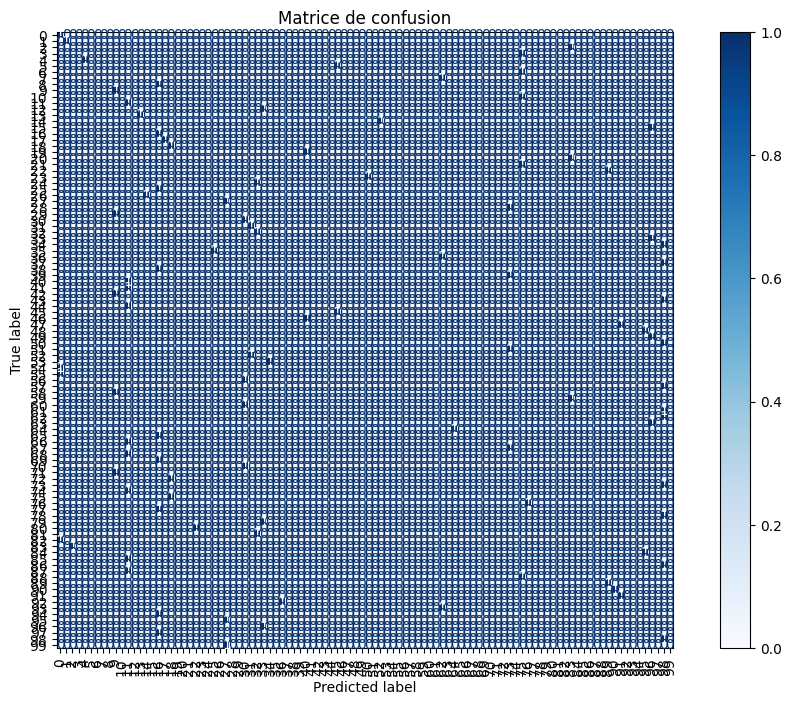

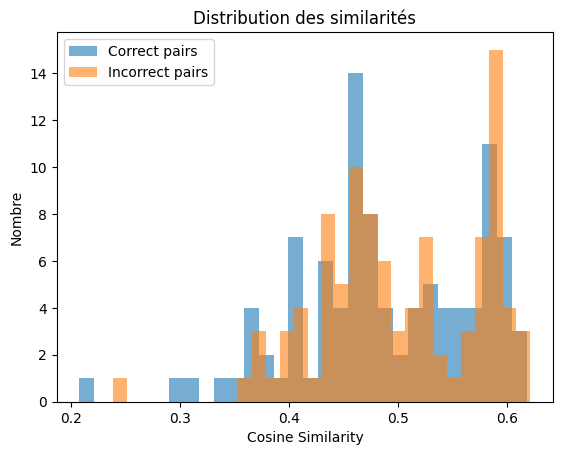

In [72]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import psutil

# -------------------------------
# 1️⃣ Cosine similarity entre toutes les images et toutes les fiches
# -------------------------------
start_time = time.time()
similarities = cosine_similarity(img_embeds.cpu().numpy(), txt_embeds.cpu().numpy())
elapsed_time = time.time() - start_time
print(f"Temps total pour calculer les similarités : {elapsed_time:.2f} sec")
print(f"Temps moyen par image : {elapsed_time / similarities.shape[0]:.4f} sec")

# Mémoire utilisée
process = psutil.Process()
print(f"Utilisation mémoire : {process.memory_info().rss / 1024**2:.2f} MB")

# -------------------------------
# 2️⃣ Top-k, MRR, Precision@k, Recall@k
# -------------------------------
def evaluate_topk(sim_matrix, k=5):
    num_images = sim_matrix.shape[0]
    top1_acc = 0
    top5_acc = 0
    mrr = 0
    precision_k = 0
    recall_k = 0

    for i in range(num_images):
        ranks = (-sim_matrix[i]).argsort()  # indices triés décroissant
        rank = np.where(ranks == i)[0][0] + 1  # rang correct (1-indexé)

        mrr += 1 / rank
        if rank == 1: top1_acc += 1
        if rank <= k: top5_acc += 1

        topk = ranks[:k]
        precision_k += (i in topk) / k
        recall_k += int(i in topk)

    return {
        "Top-1 Accuracy": top1_acc / num_images,
        f"Top-{k} Accuracy": top5_acc / num_images,
        "MRR": mrr / num_images,
        f"Precision@{k}": precision_k / num_images,
        f"Recall@{k}": recall_k / num_images
    }

metrics = evaluate_topk(similarities, k=5)
print(metrics)

# -------------------------------
# 3️⃣ F1-score (micro)
# -------------------------------
y_true = np.arange(similarities.shape[0])
y_pred = similarities.argmax(axis=1)
f1 = f1_score(y_true, y_pred, average='micro')
print(f"F1 score (micro) : {f1:.4f}")

# -------------------------------
# 4️⃣ Matrice de confusion
# -------------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(12, 8))
disp.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')  # ax=plt.gca() lie au subplot actuel
plt.title("Matrice de confusion")
plt.show()

# -------------------------------
# 5️⃣ Distribution des similarités
# -------------------------------
correct_sim = similarities[np.arange(len(y_true)), y_true]
incorrect_sim = similarities.copy()
for i in range(len(y_true)):
    incorrect_sim[i, y_true[i]] = -1  # ignorer la bonne valeur
incorrect_sim = incorrect_sim.max(axis=1)

plt.hist(correct_sim, bins=30, alpha=0.6, label='Correct pairs')
plt.hist(incorrect_sim, bins=30, alpha=0.6, label='Incorrect pairs')
plt.xlabel("Cosine Similarity")
plt.ylabel("Nombre")
plt.legend()
plt.title("Distribution des similarités")
plt.show()
